In [1]:
from msdm.domains import GridWorld
from msdm.algorithms.entregpolicyiteration import entropy_regularized_policy_iteration
from msdm.algorithms import ValueIteration
from msdm.core.problemclasses.mdp import TabularPolicy
from algorithms import MaxLikelihoodIRL
import torch
from frozendict import frozendict
from dataset import TrajectoryDataset
from torch.utils.data import DataLoader

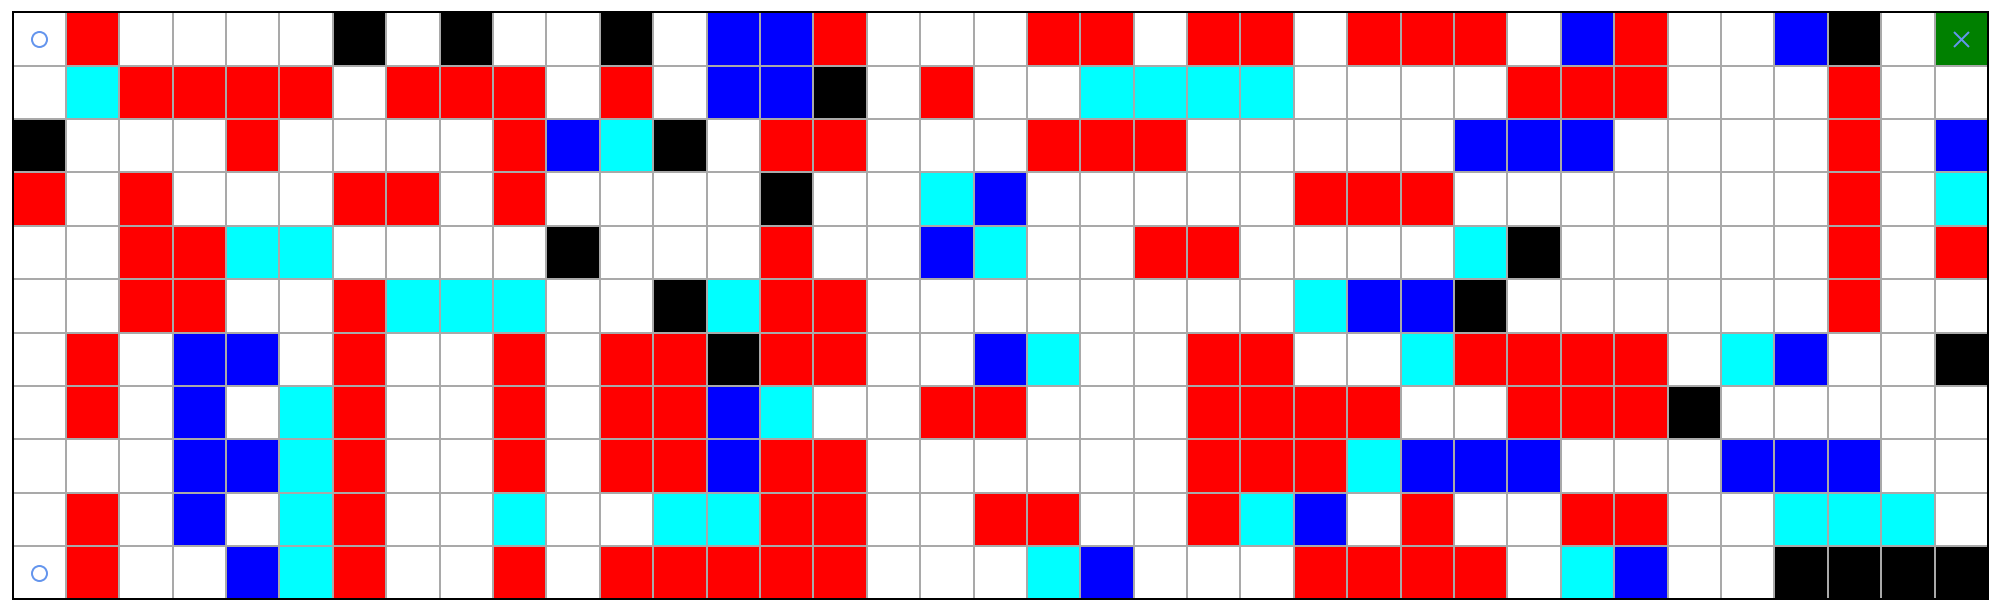

In [2]:
# Create a gridworld
mdp_params = dict(
    tile_array=[
      "sx....c.c..c.bbx...xx.xx.xxx.bx..bc.g",
      ".axxxx.xxx.x.bbc.x..aaaa....xxx...x..",
      "c...x....xbac.xx...xxx.....bbb....x.b",
      "x.x...xx.x....c..ab.....xxx.......x.a",
      "..xxaa....c...x..ba..xx....ac.....x.x",
      "..xx..xaaa..caxx........abbc......x..",
      ".x.bb.x..x.xxcxx..ba..xx..axxxx.ab..c",
      ".x.b.ax..x.xxba..xx...xxxx..xxxc.....",
      "...bbax..x.xxbxx......xxxabbb...bbb..",
      ".x.b.ax..a..aaxx..xx..xab.x..xx..aaa.",
      "sx..bax..x.xxxxx...ab...xxxx.ab..cccc",
    ],
    feature_rewards={
      'g': 10,
      'x': -500,
      'c': -5,
      '.': 0,
      'a': 0,
      'b': 0,
    },
    absorbing_features=('g'),
    initial_features=('s'),
    discount_rate=1-1e-5,
    step_cost=-1
)
mdp = GridWorld(**mdp_params)

featurecolors = {
    'g': 'green',
    'x': 'red',
    '.': 'white',
    'b': 'blue',
    'a': 'cyan',
    'c': 'black'
}
mdp.plot(featurecolors=featurecolors)


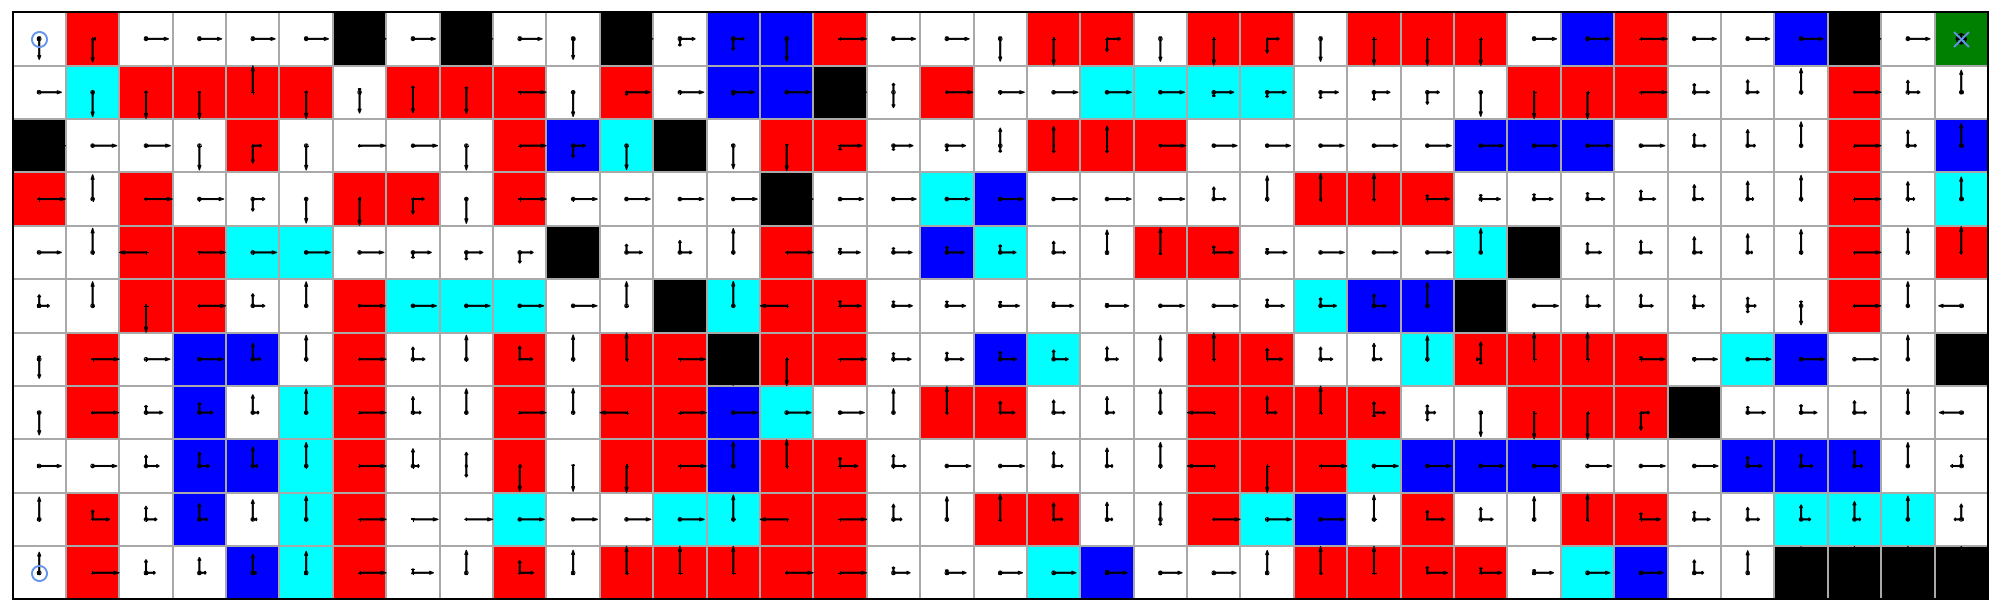

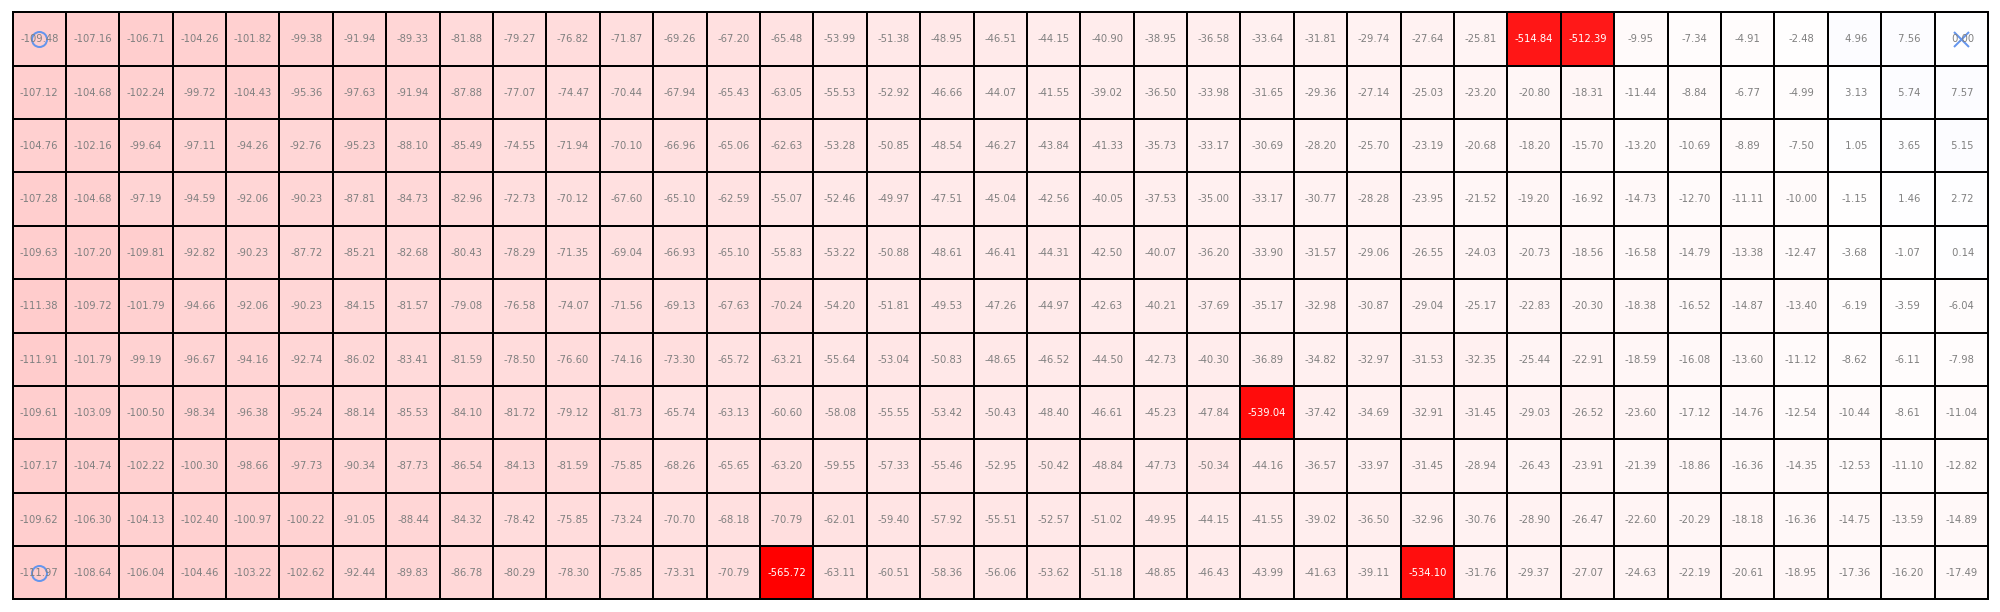

In [3]:
# Expert has a optimal policy
# vi_res = ValueIteration().plan_on(mdp)
# expert_policy = vi_res.policy
# mdp.plot(featurecolors=featurecolors).plot_policy(expert_policy)

# Use the Maximum Entropy IRL policy to generate trajectories
expert_erpi_params = dict(
    transition_matrix=torch.tensor(mdp.transition_matrix),
    reward_matrix=torch.tensor(mdp.reward_matrix),
    discount_rate=torch.tensor(mdp.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([1]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

# Max Entropy IRL expert policy
expert_erpi = entropy_regularized_policy_iteration(
    **expert_erpi_params
)

expert_policy = TabularPolicy.from_matrix(
    states=mdp.state_list,
    actions=mdp.action_list,
    policy_matrix=expert_erpi.policy.detach().numpy()
)

expert_state_values = dict(zip(mdp.state_list, expert_erpi.state_values))
mdp.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp.plot().plot_state_map(expert_state_values)


In [4]:
# Generate gen_iters of trajectories
gen_iters = 10000
trajectories = []

for _ in range(gen_iters):
  # Starts at one of the labelled starting points
  trajectory = expert_policy.run_on(mdp)
  formatted_traj = {}
  formatted_traj['state_traj'] = trajectory.state_traj
  formatted_traj['action_traj'] = trajectory.action_traj
  trajectories.append(formatted_traj)

trajs_dataset = TrajectoryDataset(trajectories)

In [5]:
def featurizer(state, action, next_state):
  feature_name = mdp.location_features.get(next_state, 's')
  if feature_name in 'sg':
    return {}
  return {feature_name: 1}

def fixed_reward(state, action, next_state):
  return mdp.step_cost

In [6]:
algorithm = MaxLikelihoodIRL(mdp, featurizer, fixed_reward, batch_size=64, epochs=50)
learned_weights, the_policy = algorithm.learn(trajs_dataset)

Inital reward weights: tensor([ 0.4723,  1.0968, -0.3391, -0.2026], dtype=torch.float64)

loss: 0.308192  [    0/10000]
loss: 0.297954  [  128/10000]
loss: 0.286388  [  256/10000]
loss: 0.289706  [  384/10000]
loss: 0.267118  [  512/10000]
loss: 0.282148  [  640/10000]
loss: 0.273076  [  768/10000]
loss: 0.268046  [  896/10000]
loss: 0.282545  [ 1024/10000]
loss: 0.261339  [ 1152/10000]
loss: 0.262767  [ 1280/10000]
loss: 0.260397  [ 1408/10000]
loss: 0.265377  [ 1536/10000]
loss: 0.267921  [ 1664/10000]
loss: 0.256234  [ 1792/10000]
loss: 0.256838  [ 1920/10000]
loss: 0.255246  [ 2048/10000]
loss: 0.248188  [ 2176/10000]
loss: 0.238887  [ 2304/10000]
loss: 0.261753  [ 2432/10000]
loss: 0.248460  [ 2560/10000]
loss: 0.249613  [ 2688/10000]
loss: 0.240932  [ 2816/10000]
loss: 0.243346  [ 2944/10000]
loss: 0.242184  [ 3072/10000]
loss: 0.247508  [ 3200/10000]
loss: 0.232164  [ 3328/10000]
loss: 0.237115  [ 3456/10000]
loss: 0.223222  [ 3584/10000]
loss: 0.237980  [ 3712/10000]
loss: 0.23

In [ ]:
# solve with matrices returned by gridworld object
my_policy = TabularPolicy.from_matrix(
    states=mdp.state_list,
    actions=mdp.action_list,
    policy_matrix=the_policy.policy.detach().numpy()
)

my_state_values = dict(zip(mdp.state_list, the_policy.state_values.detach()))
mdp.plot(featurecolors=featurecolors).plot_policy(my_policy)
mdp.plot().plot_state_map(my_state_values)

mdp.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp.plot().plot_state_map(expert_state_values)


In [ ]:
print(f"Learned policy's initial value: {my_policy.evaluate_on(mdp).initial_value}")
print(f"Expert's policy initial value: {expert_policy.evaluate_on(mdp).initial_value}")


In [ ]:
# Test learned reward weights on a novel gridworld
mdp2_params = dict(
    tile_array=[
        "sx....c.c..c.bbx...bc.g",
        ".axxxx.xxx.bb..xxx..x..",
        "c...x....xbac.xx..bb..b",
        "x.x...xx......xxx...x.a",
        "..xaa..cx..ba.....ac..x",
        "..xx..xaaa..cax.....x..",
        ".x.bb.x..x.xxcxx..ab..c",
        ".x.b.ax..a..x.xxxc.....",
        "...bbax..x.x.bb...bbb..",
        ".x.b.ax..a..a..xx..aaa.",
        "sx..bax..xb.xx.ab....cc",
    ],
    feature_rewards={
        'g': 10,
        'x': -500,
        'c': -5,
        '.': 0,
        'a': 0,
        'b': 0,
    },
    absorbing_features=('g'),
    initial_features=('s'),
    discount_rate=1-1e-5,
    step_cost=-1
)
mdp2 = GridWorld(**mdp2_params)

mdp2.plot(featurecolors=featurecolors)


In [ ]:
expert_erpi_params = dict(
    transition_matrix=torch.tensor(mdp2.transition_matrix),
    reward_matrix=torch.tensor(mdp2.reward_matrix),
    discount_rate=torch.tensor(mdp2.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([1]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)

# Max Entropy IRL expert policy
expert_erpi = entropy_regularized_policy_iteration(
    **expert_erpi_params
)

expert_policy = TabularPolicy.from_matrix(
    states=mdp2.state_list,
    actions=mdp2.action_list,
    policy_matrix=expert_erpi.policy.detach().numpy()
)

expert_state_values = dict(zip(mdp2.state_list, expert_erpi.state_values))
mdp2.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp2.plot().plot_state_map(expert_state_values)


In [ ]:
def featurizer(state, action, next_state):
  feature_name = mdp2.location_features.get(next_state, 's')
  if feature_name in 'sg':
    return {}
  return {feature_name: 1}


def fixed_reward(state, action, next_state):
  return mdp2.step_cost


In [ ]:
algorithm2 = MaxLikelihoodIRL(mdp2, featurizer, fixed_reward, batch_size=64, epochs=50)

# compute policy from learned weights
feature_reward_matrix2 = torch.einsum(
    "sanf,f->san",
    algorithm2.get_feature_matrix(),
    learned_weights
)

reward_matrix2 = feature_reward_matrix2 + algorithm2.get_fixed_reward_matrix()
terminal_index = mdp2.state_index.get(
    frozendict({'x': -1, 'y': -1}))
reward_matrix2[:, :, terminal_index] = 0

my_erpi_params = dict(
    transition_matrix=torch.tensor(mdp2.transition_matrix),
    reward_matrix=reward_matrix2,
    discount_rate=torch.tensor(mdp2.discount_rate),
    # the lower this is, the more optimal the policy
    entropy_weight=torch.tensor([1]),
    n_planning_iters=10,
    policy_prior=None,
    initial_policy=None,
    check_convergence=True,
    force_nonzero_probabilities=True,
)


In [ ]:
# solve with matrices returned by gridworld object
my_erpi = entropy_regularized_policy_iteration(
    **my_erpi_params
)

my_policy = TabularPolicy.from_matrix(
    states=mdp2.state_list,
    actions=mdp2.action_list,
    policy_matrix=my_erpi.policy.detach().numpy()
)

my_state_values = dict(zip(mdp2.state_list, my_erpi.state_values.detach()))
mdp2.plot(featurecolors=featurecolors).plot_policy(my_policy)
mdp2.plot().plot_state_map(my_state_values)

mdp2.plot(featurecolors=featurecolors).plot_policy(expert_policy)
mdp2.plot().plot_state_map(expert_state_values)


In [ ]:
print(f"Learned policy's initial value: {my_policy.evaluate_on(mdp2).initial_value}")
print(f"Expert's policy initial value: {expert_policy.evaluate_on(mdp2).initial_value}")
